<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divided differences using sparse matrix

Import the usual modules

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [32]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [33]:
#compressed sparse row CSR
def fd(N):
    #compute fd mtrix insparse form using compressed sparse row format 
    data=[-np.ones(N+1), np.ones(N)]
    return sp.diags(data,[0,1], format="csr")

In [34]:
help(sp.diags)

Help on function diags in module scipy.sparse._construct:

diags(diagonals, offsets=0, shape=None, format=None, dtype=None)
    Construct a sparse matrix from diagonals.
    
    Parameters
    ----------
    diagonals : sequence of array_like
        Sequence of arrays containing the matrix diagonals,
        corresponding to `offsets`.
    offsets : sequence of int or an int, optional
        Diagonals to set:
          - k = 0  the main diagonal (default)
          - k > 0  the kth upper diagonal
          - k < 0  the kth lower diagonal
    shape : tuple of int, optional
        Shape of the result. If omitted, a square matrix large enough
        to contain the diagonals is returned.
    format : {"dia", "csr", "csc", "lil", ...}, optional
        Matrix format of the result. By default (format=None) an
        appropriate sparse matrix format is returned. This choice is
        subject to change.
    dtype : dtype, optional
        Data type of the matrix.
    
    See Also
    -

Exmaple of Forward Difference matrix

In [35]:
#fix a grid
a=0
b=1
N=5
h=(b-a)/N
D=fd(N)/h

In [36]:
print(D)

  (0, 0)	-5.0
  (0, 1)	5.0
  (1, 1)	-5.0
  (1, 2)	5.0
  (2, 2)	-5.0
  (2, 3)	5.0
  (3, 3)	-5.0
  (3, 4)	5.0
  (4, 4)	-5.0
  (4, 5)	5.0
  (5, 5)	-5.0


In [37]:
print(D.todense())

[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Test: use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [38]:
import time

In [39]:
# Fix function f using symbolic tool
t = sym.var('t')
fsym = 0.5 * t**2
# Define the function as an inline function
f = sym.lambdify(t, fsym )

timesparse=np.zeros(200)

for i in range(200):
    start=time.time()
    # Set up interval and cardinality of the grid
    a=0
    b=1
    N=5*i+1
    h=(b-a)/N

    # set up grid points
    x=np.linspace(a,b,N+1)

    # Evaluate FD matrix
    D=fd(N)/h

    # Values of the derivative at the grid points
    uh=D.dot(f(x))[1:N]
    end=time.time()
    timesparse[i]=end-start

# Print results
#print(uh)

Compute max error

In [40]:
fdsym=fsym.diff(t,1)
fd=sym.lambdify(t,fdsym)

print(max(abs(uh-fd(x[1:N]))))

0.0005020080322420961


**Exercise 1.** Find a way to evaluate execution time and compare full vs sparse exectution time in function of the grid size N.

In [41]:
def fd(a,b,n):
    h=(b-a)/n
    fd=np.zeros((n+1,n+1))

    for i in range(n):
        fd[i,i]=-1
        fd[i,i+1]=1

    return fd/h

In [42]:
t = sym.var('t')
fsym = 0.5 * t**2
f = sym.lambdify(t, fsym)

NN = np.zeros(200)
times= np.zeros(200)

for i in range(200):
    start=time.time()
    a=0
    b=1
    N=5*i+1
    h=(b-a)/N
    NN[i]=N

    x=np.linspace(a,b,N+1)

    fd_mat = fd(a,b,N)
    u_x=fd_mat.dot(f(x))[1:N]
    end=time.time()
    times[i]=end-start

Text(0.5, 0, 'grid size')

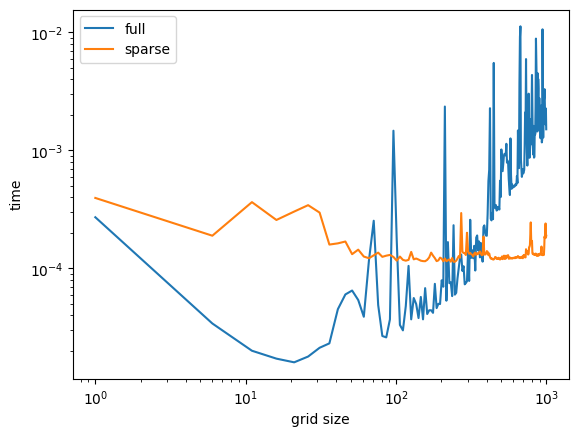

In [43]:
import matplotlib.pyplot

plt.loglog(NN,times, label='full')
plt.loglog(NN,timesparse, label='sparse')
plt.legend()
plt.ylabel('time')
plt.xlabel('grid size')

# Finite Differences for two-points boundary value problems with constant coefficients

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [44]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a
  # uniform grid in sparse CSR format
  data= [np.ones(N), -2*np.ones(N+1), np.ones(N)]
  return sp.diags(data, [-1,0,1], format="csr")

Example of second central matrix.

In [45]:
N=5
A=CD2(N)
print(A.todense())

[[-2.  1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

u(x)=sin(x)

In [46]:
# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = sym.sin(t)
u = sym.lambdify(t, fsym )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [47]:
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
#removing first and last
F=-h**2*f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A=A[1:-1,1:-1]


Import solver

In [48]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

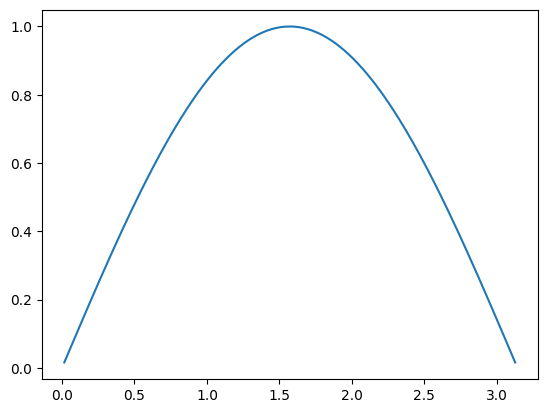

In [49]:
# Compute solution at internal nodes
uh=spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

In [50]:
# print max error

print(np.max(np.abs(uh-u(x[1:-1]))))

2.0561929504392396e-05


**Exercise 2.** test for convergence and plot convergence plot

In [51]:
no_expe = 7
error = np.zeros(no_expe)
nn = np.zeros(no_expe)

for i in range(no_expe):
    n = 2**(i+1)
    nn[i] = n
    h = (b - a) / n
    x = np.linspace(a, b, n+1)

    A = CD2(n)
    F = -h**2 * f(x[1:-1])
    A = A[1:-1, 1:-1]
    uh = spsolve(A, F)
    error[i] = np.max(np.abs(uh - u(x[1:-1])))

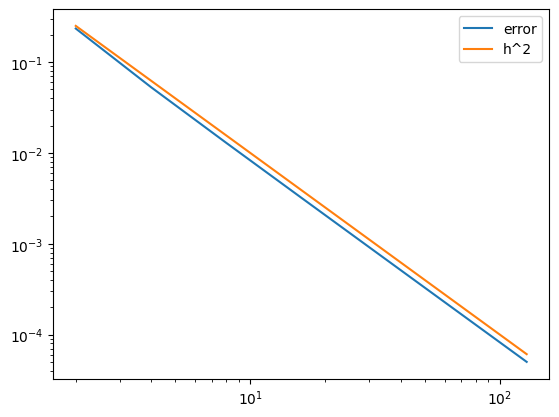

In [52]:
plt.loglog(nn, error, label='error')
matplotlib.pyplot.loglog(nn,nn**(-2), label = 'h^2')
plt.legend()

**Exercise 3.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

In [53]:
t = sym.var('t')
fsym = -0.5 * sym.sin(t)
f = sym.lambdify(t, fsym)

# Define exact solution
usym = -0.5 * sym.sin(t)
u = sym.lambdify(t, usym)

In [54]:
alpha = 0.0  #value at the left boundary
beta = 1.0   #value at the right boundary
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*f(x[1:-1])

# Nonhomogeneous Dirichlet boundary conditions
A=A[1:-1,1:-1]

A[0,:]=0
A[0,0]=1
F[0]=alpha

A[-1,:]=0
A[-1,-1]=1
F[-1]=beta

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


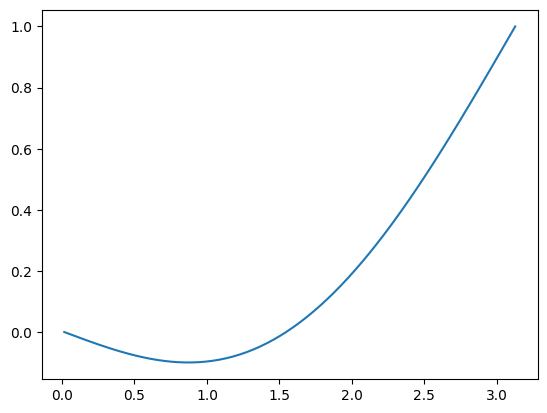

In [55]:
# Compute solution at internal nodes
uh=spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

**Exercise 4.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

In [56]:
t = sym.var('t')
fsym = -sym.sin(t)
f = sym.lambdify(t, fsym)

# Define exact solution
usym = -sym.sin(t)
u = sym.lambdify(t, usym)

In [57]:
alpha = 1.0  #value at the left boundary
neumann_right = 0.0  #Neumann condition at the right boundary

# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*f(x[1:-1])

# boundary conditions
A=A[1:-1,1:-1]

A[0,:]=0
A[0,0]=1
F[0]=alpha

A[-1, -1] = 1
A[-1, -2] = -1
F[-1]+=neumann_right*h

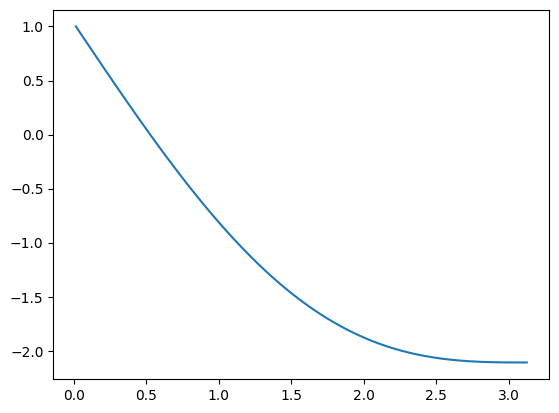

In [58]:
# Compute solution at internal nodes
uh=spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

**Exercise 5.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


In [59]:
one = 0.0  #value at the left boundary
two = 1.0   #value at the right boundary

alpha=1.
beta=1.
gamma=1.

# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# matrix
diagonals = [
    -2 * alpha / h ** 2 + gamma,  # main diagonal
    alpha / h ** 2 + beta / (2 * h),  # superdiagonal
    alpha / h ** 2 - beta / (2 * h)  # subdiagonal
]
A= sp.diags(diagonals, [0, 1, -1], shape=(N+1, N+1), format='csr')

# Right-hand side
F=-f(x[1:-1])

# Nonhomogeneous Dirichlet boundary conditions
A=A[1:-1,1:-1]

A[0,:]=0
A[0,0]=1
F[0]=one

A[-1,:]=0
A[-1,-1]=1
F[-1]=two

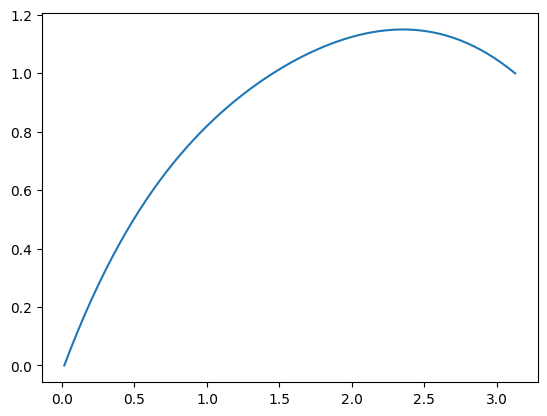

In [60]:
# Compute solution at internal nodes
uh=spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)